# Problem statement

> __Problem #2__: PiedPiper has decided to diversify their business and is planning to open a retail store in the capital city of each of the states in the USA. They have also decided to use Azure Data Centers to support the operations at each of these new retail stores however they are yet to decide on the number of data centers they should use and how they should allocate a data center to a retail store. Can you design a solution for retail store to data center allocation to help PiedPiper expand optimally?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine

In [2]:
f_path = 'us_state_capitals.json'
cap = pd.read_json(f_path, orient='index')
cap.drop(index=['AK','HI'], inplace=True)

## Assumptions
 1. For simplicity we consider only Mainland-US excluding `Washington DC`(not a state), `Hawaii`(HI) and `Alasaka`(AK).
 2. The cost of connecting [or disconnecting] a data center to a retail store is directly proportional to the distance between them. (This is a parametrized function which can be altered and need not be based on distance) 
   - i.e., $$Cost \propto Distance$$ 
   - Since non-eucledian geometry, distance is calculated as "_Great-circle distance between two points on a sphere given their longitudes and latitudes_" using haversine formula.
 3. Setting up a data center will have an initial cost: `I`
 4. We will start with one or more data center and only expand the number of data centers at a rate of upto 4 per expansion-step. (This is to reduce the computational complexity)
 5. During an expansion to next stage, we will not discard the data center from previous step. Instead, if a retail center is closer to a new data center, we will disconnect from current one and connect to the new data center. Cost of disconnecting is regarded as sunk cost from expansion to next stage.
 6. One data center can support all retail stores.

In [4]:
from mpl_toolkits.basemap import Basemap

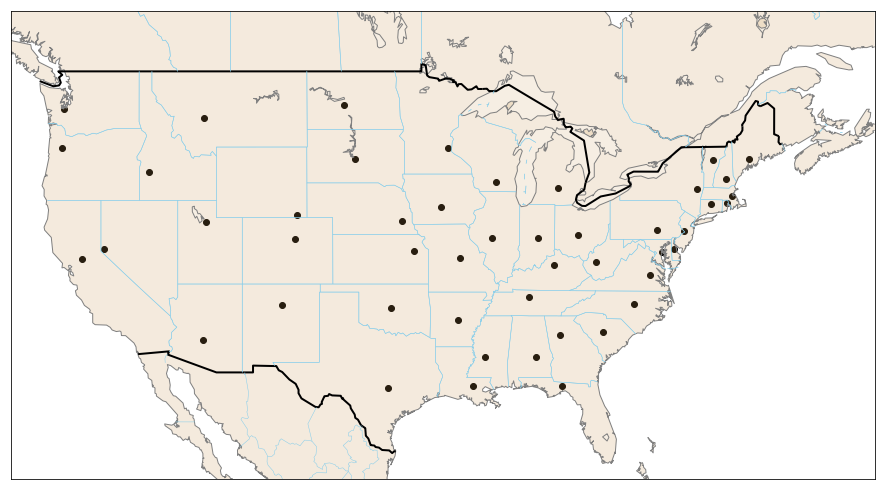

In [5]:
# create new figure, axes instances.
fig=plt.figure(figsize=(15,10))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-127.,llcrnrlat=24.,urcrnrlon=-60, urcrnrlat=52,
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines(color='grey')
m.fillcontinents(color='#cc9955',alpha=0.2,lake_color='white')
m.drawcountries(linewidth=2)
m.drawstates(color='skyblue')
x, y = m(cap['long'].values,cap['lat'].values)
m.scatter(x,y,latlon=False,marker='o',color='black')
plt.show()

In [38]:
# explain clustering process
from cluster import Cluster, path_cost

In [7]:
# creating expansion search trees
expansion_paths = \
[[i,j,k,l]
 for i in range(1,8) 
 for j in range(1,8) 
 for k in range(1,8) 
 for l in range(1,8) 
 if 5<(i+j+k+l)<10]

In [8]:
expansion_cost=[]
expansion_centers=[]
for p in expansion_paths:
    co, cen = path_cost(p,list(zip(cap.lat,cap.long)))
    expansion_centers.append(cen)
    expansion_cost.append(co)

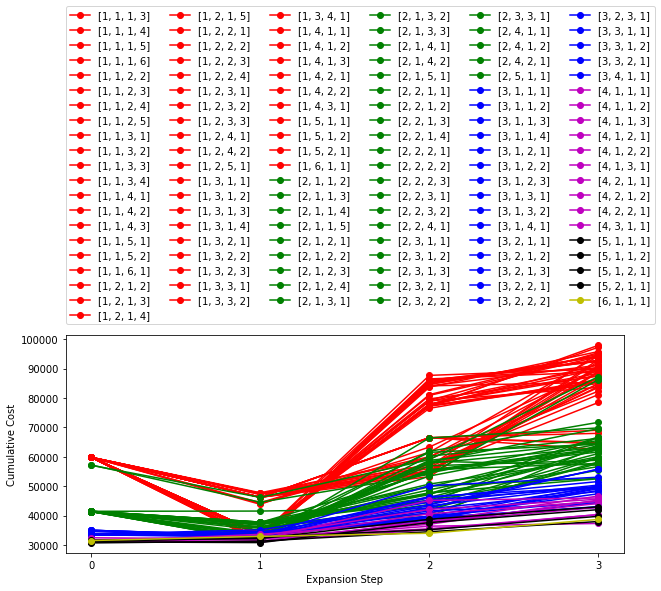

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
colors = ' rgbmkyc'
for i, ep_c in enumerate(expansion_cost):
    ax.plot(ep_c, '-o', label=expansion_paths[i], color=colors[expansion_paths[i][0]])
plt.xticks(np.arange(0,4))
plt.xlabel('Expansion Step')
plt.ylabel('Cumulative Cost')
plt.legend(loc=(0,1.05), ncol=6)
plt.show()

## Observations

 - The more the number of data-centers that you start with initially, lesser the final cost as well as cost per expansion.
 - Ideal path should have low cumulative cost and low volatility (so that finanaces is uniterrupted).

Lets examine the initial and final cost distribution based on the initial number of clusters:

In [10]:
initial_cost=[(p[0],expansion_cost[i][0]) for i, p in enumerate(expansion_paths)]
final_cost=[(p[0],expansion_cost[i][-1]) for i, p in enumerate(expansion_paths)]

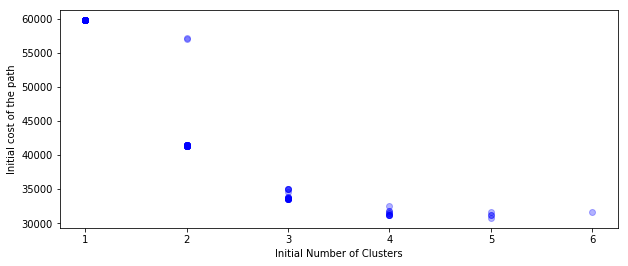

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
for point in initial_cost:
    ax.plot(point[0],point[1],'o',color='blue', alpha=0.3)
plt.xlabel('Initial Number of Clusters')
plt.ylabel('Initial cost of the path')
plt.show()

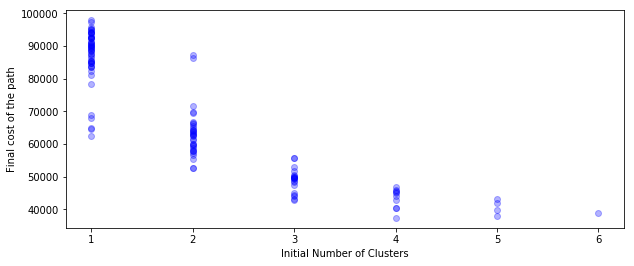

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
for point in final_cost:
    ax.plot(point[0],point[1],'o',color='blue', alpha=0.3)
plt.xlabel('Initial Number of Clusters')
plt.ylabel('Final cost of the path')
plt.show()

>There is clear dependency on the initial number of clusters in determining final cost

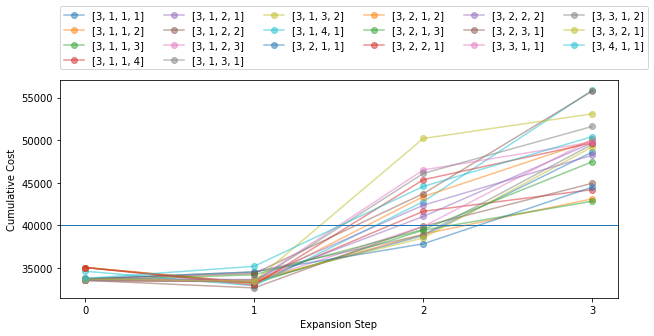

In [44]:
# lets plot all expansion paths starting initially with 3 data centers

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

for i, ep_p in enumerate(expansion_paths):
    if ep_p[0]==3:
        ax.plot(expansion_cost[i], '-o', label=expansion_paths[i], alpha=0.5)
plt.xticks(np.arange(0,4))
plt.xlabel('Expansion Step')
plt.ylabel('Cumulative Cost')
plt.legend(loc=(0,1.05), ncol=6)
plt.axhline(y=40000, linewidth=1)
plt.show()

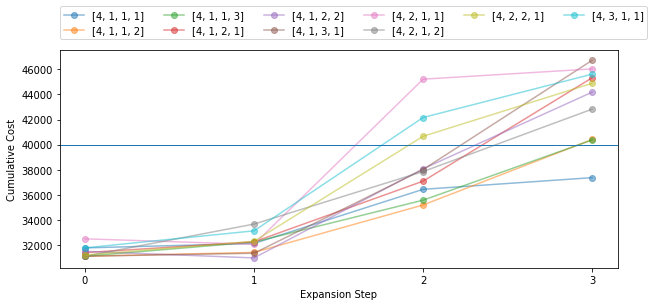

In [22]:
# lets plot all expansion paths starting initially with 4 data centers

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

for i, ep_p in enumerate(expansion_paths):
    if ep_p[0]==4:
        ax.plot(expansion_cost[i], '-o', label=expansion_paths[i], alpha=0.5)
plt.xticks(np.arange(0,4))
plt.xlabel('Expansion Step')
plt.ylabel('Cumulative Cost')
plt.legend(loc=(0,1.05), ncol=6)
plt.axhline(y=40000, linewidth=1)
plt.show()

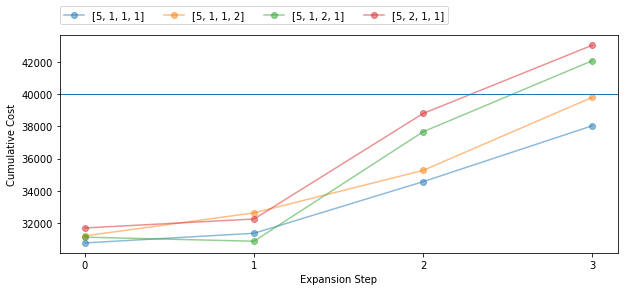

In [23]:
# lets plot all expansion paths starting initially with 5 data centers

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

for i, ep_p in enumerate(expansion_paths):
    if ep_p[0]==5:
        ax.plot(expansion_cost[i], '-o', label=expansion_paths[i], alpha=0.5)
plt.xticks(np.arange(0,4))
plt.xlabel('Expansion Step')
plt.ylabel('Cumulative Cost')
plt.legend(loc=(0,1.05), ncol=6)
plt.axhline(y=40000, linewidth=1)
plt.show()

### Best candidates:
 - The best candidate depends on how much cost can we afford to spend in the first stage.
 - If we can invest in 3 centers (max) in the begining phase, start with lowest final cost which starts with 3

In [24]:
# make a dict mapping path to centers
path_to_center = {tuple(path):expansion_centers[i] for i, path in enumerate(expansion_paths)}
path_to_cost = {tuple(path):expansion_cost[i] for i, path in enumerate(expansion_paths)}
path_to_f_cost = [(path,(expansion_cost[i][-1])) for i, path in enumerate(expansion_paths)]

In [27]:
s = sorted(path_to_f_cost, key=lambda x: x[-1])
s[:10]

[([4, 1, 1, 1], 37386.54991779068),
 ([5, 1, 1, 1], 38041.21974766231),
 ([6, 1, 1, 1], 38758.11097728959),
 ([5, 1, 1, 2], 39804.981799782254),
 ([4, 1, 1, 3], 40379.771495630834),
 ([4, 1, 1, 2], 40418.34110949682),
 ([5, 1, 2, 1], 42075.93976392378),
 ([4, 2, 1, 2], 42830.2770146513),
 ([3, 1, 1, 3], 42844.71646549388),
 ([5, 2, 1, 1], 43037.62845965996)]

In [35]:
chosen_path_index = 8
f_cent = path_to_center[tuple(s[chosen_path_index][0])]
path_to_cost[tuple(s[chosen_path_index][0])]

[35064.790994977644, 33182.07574403555, 39444.77859996315, 42844.71646549388]

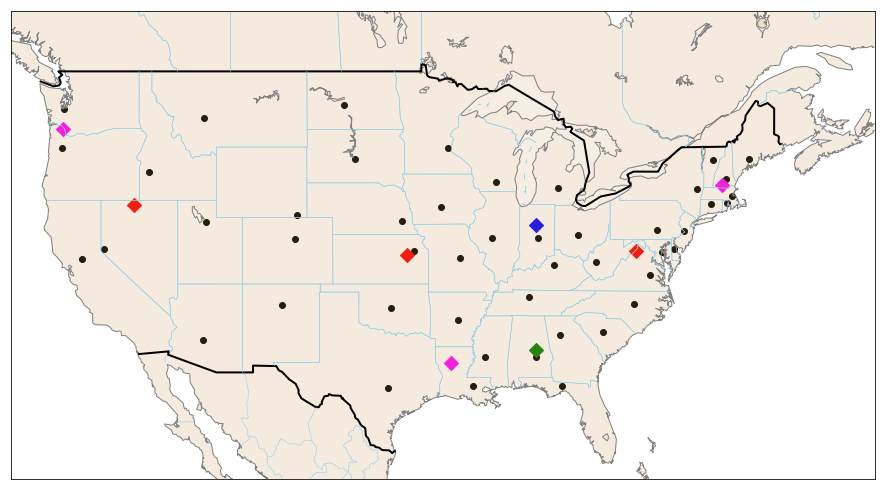

In [37]:
# create new figure, axes instances.
fig=plt.figure(figsize=(15,10))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-127.,llcrnrlat=24.,urcrnrlon=-60, urcrnrlat=52,
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines(color='grey')
m.fillcontinents(color='#cc9955',alpha=0.2,lake_color='white')
m.drawcountries(linewidth=2)
m.drawstates(color='skyblue')
x, y = m(cap['long'].values,cap['lat'].values)
m.scatter(x,y,latlon=False,marker='o',color='black')


# First stage
x1, y1 = m([long for _, long in f_cent[0]],[lat for lat, _ in f_cent[0]])
m.scatter(x1,y1,latlon=False,marker='D',s=100,color='red')

# Second stage
x2, y2 = m([coord[1] for coord in f_cent[1] if coord not in f_cent[0]],
           [coord[0] for coord in f_cent[1] if coord not in f_cent[0]])
m.scatter(x2,y2,latlon=False,marker='D',s=100,color='green')


# Second stage
x3, y3 = m([coord[1] for coord in f_cent[2] if coord not in (f_cent[0]+f_cent[1])],
           [coord[0] for coord in f_cent[2] if coord not in (f_cent[0]+f_cent[1])])
m.scatter(x3,y3,latlon=False,marker='D',s=100,color='blue')

# Second stage
x4, y4 = m([coord[1] for coord in f_cent[3] if coord not in (f_cent[0]+f_cent[1]+f_cent[2])],
           [coord[0] for coord in f_cent[3] if coord not in (f_cent[0]+f_cent[1]+f_cent[2])])
m.scatter(x4,y4,latlon=False,marker='D',s=100,color='magenta')

plt.show()